In [2]:
#!pip install -U --pre tensorflow=="2.*"

In [1]:
!pip install pycocotools

In [2]:
!pip install tensorflow_hub

In [2]:


import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
           os.chdir('..')
elif not pathlib.Path('models').exists():
          !git clone --depth 1 https://github.com/tensorflow/models



In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.


In [4]:
%%bash 
cd models/research
pip install .

Processing /home/home/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1017618 sha256=6129f7e1ff16a7e60d667eb8a593af7e180b2760da047af9f4c64a547b34f67a
  Stored in directory: /tmp/pip-ephem-wheel-cache-efdce8zj/wheels/24/b7/1c/980097304996aa9afd9ab1bc2f24a01cffa279c042315a0da5
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [6]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [7]:


# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile



In [8]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model



In [9]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/home/elasticfleet/training_demo/models/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS


[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg'),
 PosixPath('models/research/object_detection/test_images/sample_image.jpg'),
 PosixPath('models/research/object_detection/test_images/sample_image2.jpg')]

In [12]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
print(detection_model.inputs)


[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [14]:
detection_model.output_dtypes

{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [15]:
detection_model.output_shapes

{'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_scores': TensorShape([None, 100])}

In [16]:
def run_inference_for_single_image(model, image):
          image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
          input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
          input_tensor = input_tensor[tf.newaxis,...]
    
    

  # Run inference
          output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
          num_detections = int(output_dict.pop('num_detections'))
          output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
          output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
          output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
          if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
            detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
            output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
          return output_dict



In [17]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
      image_np = np.array(Image.open(image_path))
  # Actual detection.
      output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

      display(Image.fromarray(image_np))

Number of people in the image are:  0


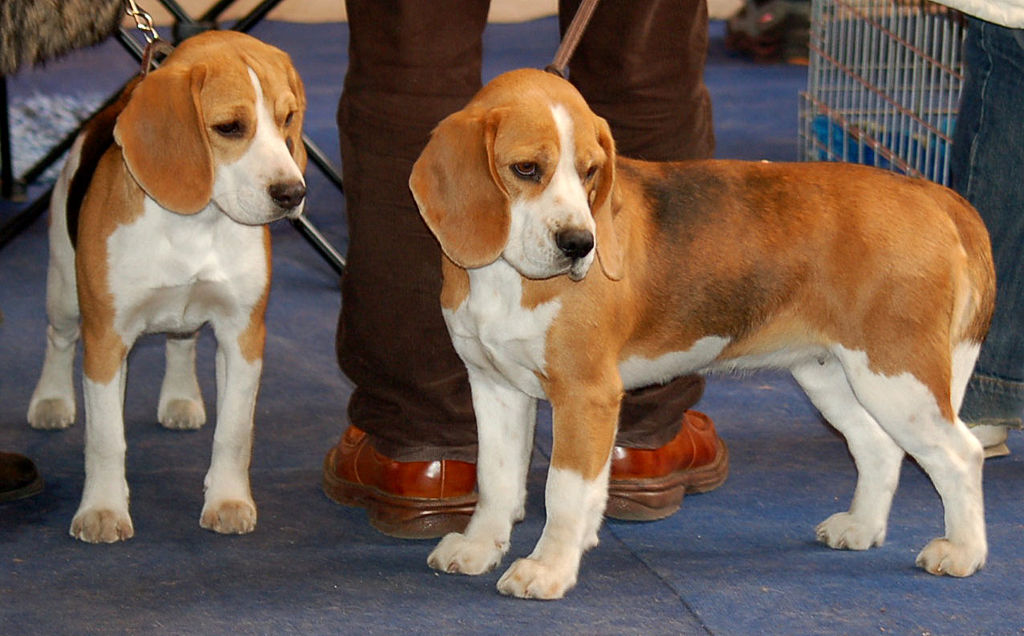

Number of people in the image are:  6


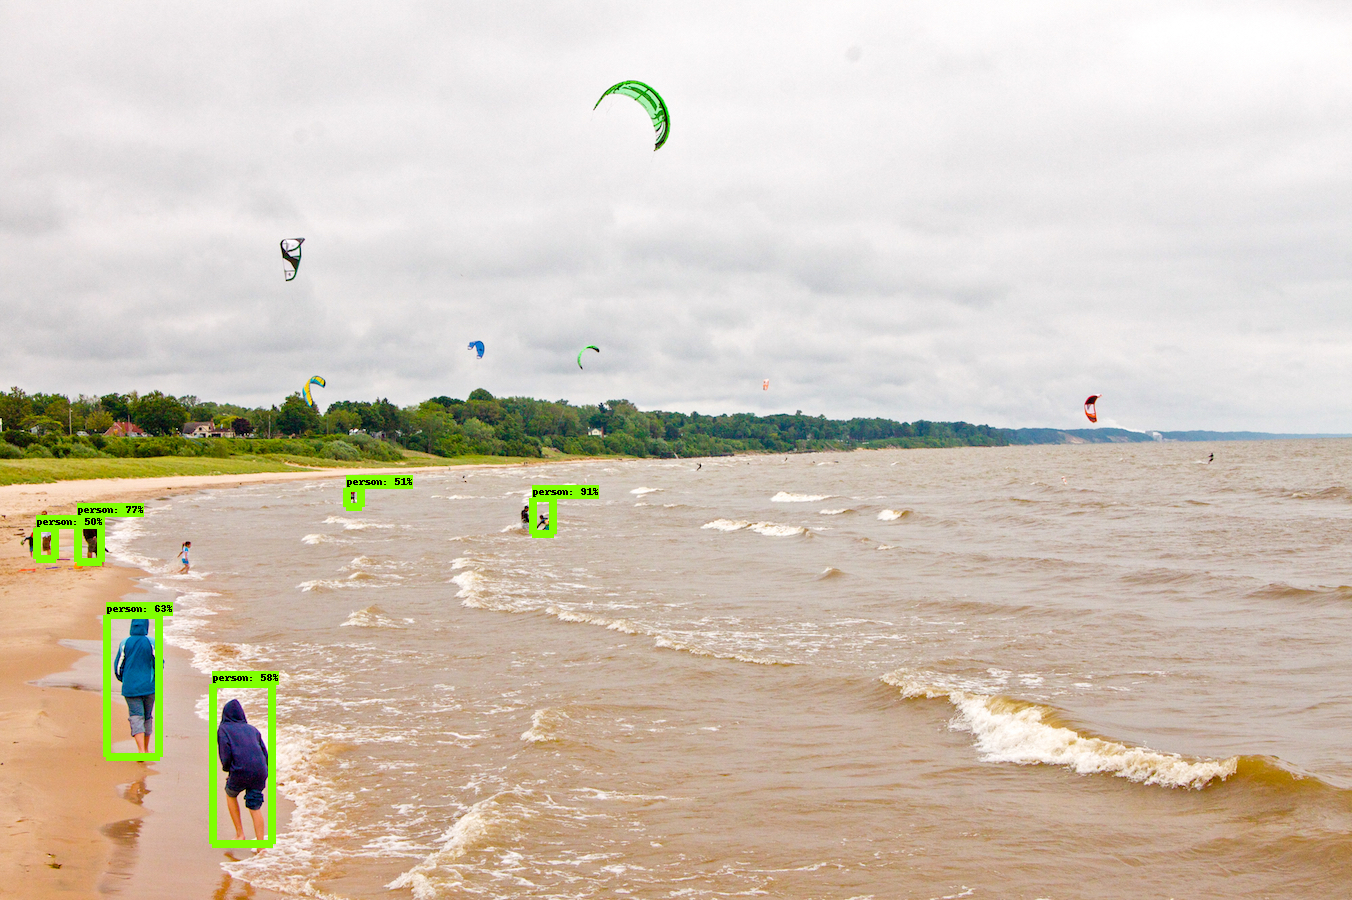

Number of people in the image are:  7


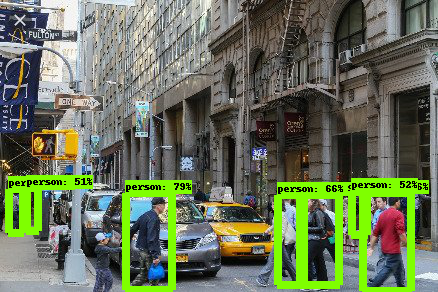

Number of people in the image are:  4


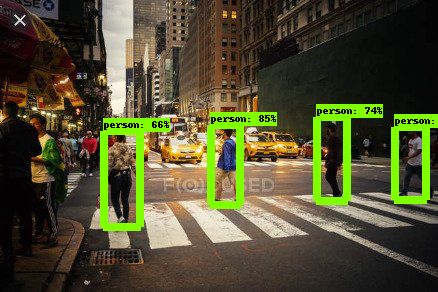

In [18]:
for image_path in TEST_IMAGE_PATHS:
      show_inference(detection_model, image_path)


In [17]:
#model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
#masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

In [18]:
#masking_model.output_shapes


In [19]:
#for image_path in TEST_IMAGE_PATHS:
 #     show_inference(masking_model, image_path)
